# Анализ лояльности пользователей Яндекс Афиши

- Автор: Гладков Максим
- Дата: 05.12.2025

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1385]:
import os
import pandas as pd
import numpy as np
import phik

from sqlalchemy import create_engine
from dotenv import load_dotenv
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Служебные функции

In [1386]:
def unique_values(df, columns):
    """
    Функция выводит уникальные значения в указанных столбцах
    df      - DataFrame
    columns - список полей
    """
    for column in columns:
        print(f'Уникальные значения в столбце {column}:')
        print(df[column].sort_values().unique())
        print()

def detect_outliers_iqr(series, k=1.5, return_bounds=False):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]

    if return_bounds:
        return outliers, lower_bound, upper_bound
    else:
        return outliers
    
def print_stats(series, group_name):
    print(f"\n{group_name}:")
    print(f"  Среднее: {series.mean():.2f} руб.")
    print(f"  Медиана: {series.median():.2f} руб.")
    print(f"  25-й перцентиль: {series.quantile(0.25):.2f} руб.")
    print(f"  75-й перцентиль: {series.quantile(0.75):.2f} руб.")
    print(f"  Мин: {series.min():.2f} руб.")
    print(f"  Макс: {series.max():.2f} руб.")

---

### Шаг 1. Загрузка данных и их предобработка

Задача 1.1: Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных data-analyst-afisha

In [1387]:
# подготовка соединения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)

engine = create_engine(connection_string)

In [1388]:
# запрос на получение необходимых данных
query = '''
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    ROUND(
        EXTRACT(DAY FROM (
            p.created_dt_msk - 
            LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)
        ))::numeric,
        2
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases p
INNER JOIN afisha.events e ON p.event_id = e.event_id
JOIN afisha.city c ON e.city_id = c.city_id
JOIN afisha.regions r ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY
    p.user_id ASC,
    p.created_dt_msk ASC;
'''

In [1389]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [1390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

**Анализ общей информации о данных**
**Объём данных:**

- 290 611 записей (строк);
- 15 столбцов.

**Типы данных по группам:**

**Пропуски данных:**
- Единственный столбец с пропусками — `days_since_prev` (268 678 non‑null из 290 611), что соответствует описанию (для пользователей с одной покупкой значение пропущено).

**Оценка корректности выгрузки**
- Все ключевые поля присутствуют.
- Типы данных в целом соответствуют ожидаемым (даты в datetime, числа в float/int, текстовые поля в object).
- Пропуски в `days_since_prev` логичны и ожидаемы.
- Нет явных признаков дублирования индексов (RangeIndex от 0 до 290610).
- Объём данных (33.3 MB) адекватен для датасета такого размера.

**Шаги предобработки**
1. Проверить и при необходимости привести к единому формату:
    - `user_id`: убедиться, что это строковый тип (если используются буквенно‑цифровые ID).
    - `currency_code`: проверить уникальность значений.
2. Обработать пропуски в `days_since_prev`:
    - Оставить как есть (если пропуски семантически значимы).
3. Проверить диапазоны и аномалии:
    - `revenue`: отрицательные значения, экстремальные выбросы.
    - `tickets_count`: нулевые или очень большие значения.
4. Оптимизировать типы данных (если нужно):
    - `order_id`, `event_id`: возможно, перевести в int32, если значения позволяют.
    - Категориальные строки (`device_type_canonical`, `event_type_main` и др.): рассмотреть category для экономии памяти.
5. Проверить уникальность ключей:
    - `order_id`: должен быть уникальным.
    - `user_id`: может повторяться (много заказов от одного пользователя).

**Промежуточный вывод**
Данные выгружены корректно, пропуски логичны, типы в целом соответствуют содержанию. Требуется минимальная предобработка: проверка аномалий, обработка пропусков в `days_since_prev` и оптимизация типов (по необходимости).



---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [1391]:
url = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
exchange_rate_df = pd.read_csv(url)

In [1392]:
display(exchange_rate_df.info())
display(exchange_rate_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [1393]:
# Приводим дату к datetime
exchange_rate_df['data'] = pd.to_datetime(exchange_rate_df['data'])

In [1394]:
# Объединение данных по дате
df_with_rate = pd.merge(
    df,
    exchange_rate_df,
    left_on='order_dt',
    right_on='data',
    how='left'
)

In [1395]:
# Конвертация выручки
df_with_rate['revenue_rub'] = df_with_rate.apply(
    lambda row: (
        row['revenue'] if row['currency_code'] == 'rub' 
        else row['revenue'] * row['curs'] / 100
    ),
    axis=1
)

In [1396]:
print(
    df_with_rate[df_with_rate['currency_code'] == 'kzt']
    [['currency_code', 'revenue', 'curs', 'revenue_rub']]
    .head(10)
)

    currency_code   revenue     curs  revenue_rub
70            kzt    518.10  19.0125    98.503762
89            kzt    347.18  18.9330    65.731589
96            kzt    328.77  18.5991    61.148261
277           kzt  22021.55  19.8928  4380.702898
460           kzt   7397.66  19.9833  1478.296591
461           kzt   7397.66  19.9833  1478.296591
462           kzt   5548.24  19.9833  1108.721444
463           kzt   3698.83  19.9833   739.148295
464           kzt   7397.66  19.9833  1478.296591
515           kzt    361.08  18.4217    66.517074


In [1397]:
df['revenue_rub'] = df_with_rate['revenue_rub']

In [1398]:
print(df[df['currency_code'] == 'kzt']
    [['currency_code', 'revenue', 'revenue_rub']]
    .head(10)
)

    currency_code   revenue  revenue_rub
70            kzt    518.10    98.503762
89            kzt    347.18    65.731589
96            kzt    328.77    61.148261
277           kzt  22021.55  4380.702898
460           kzt   7397.66  1478.296591
461           kzt   7397.66  1478.296591
462           kzt   5548.24  1108.721444
463           kzt   3698.83   739.148295
464           kzt   7397.66  1478.296591
515           kzt    361.08    66.517074


**Промежуточный вывод**
1. Данные о курсе валют загружены и приведены к формату datetime.
2. Основной датасет объединён с курсом по дате заказа.
3. Выручка конвертирована в рубли:
    - для RUB — без изменений;
    - для KZT — по курсу (с учётом, что курс дан за 100 тенге).
4. Результат сохранён в столбец `revenue_rub`.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [1399]:
print(df.isnull().sum())

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64


**Результат:**

Пропуски только в `days_since_prev` (как и ожидалось) — 21 933 записей.
Остальные столбцы — без пропусков.

**Вывод:** Данные выгружены корректно, аномальных пропусков нет.

In [1400]:
# Приведение к оптимальным типам
df['user_id'] = df['user_id'].astype('string')
df['device_type_canonical'] = df['device_type_canonical'].astype('category')
df['currency_code'] = df['currency_code'].astype('category')
df['event_type_main'] = df['event_type_main'].astype('category')
df['service_name'] = df['service_name'].astype('category')
df['region_name'] = df['region_name'].astype('category')
df['city_name'] = df['city_name'].astype('category')

# Числовые столбцы с понижением разрядности
df['order_id'] = pd.to_numeric(df['order_id'], downcast='integer')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')
df['event_id'] = pd.to_numeric(df['event_id'], downcast='integer')
df['revenue_rub'] = pd.to_numeric(df['revenue_rub'], downcast='float')

In [1401]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  string        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  cate

**Обоснование:**

- **category** для категориальных строк сокращает память.
- **downcast** уменьшает размер числовых типов без потери точности.


In [1402]:
nominal_cols = df.select_dtypes(include=['object', 'category']).columns

for col in nominal_cols:
    print(f"\n--- Столбец: {col} ---")

    # Получаем уникальные значения и их количество
    unique_vals = df[col].dropna().unique()
    n_unique = len(unique_vals)
    n_missing = df[col].isna().sum()

    print(f"Уникальных значений: {n_unique}")
    print(f"Пропусков (NaN): {n_missing}")

    # Выводим топ-10 значений (или все, если их меньше 10)
    print("Значения (топ-10):")
    for val in unique_vals[:10]:
        count = (df[col] == val).sum()
        print(f"  '{val}' — {count} раз")

    # Ищем потенциальные маркеры пропусков
    possible_missing = []
    for val in unique_vals:
        if isinstance(val, str):
            val_lower = val.strip().lower()
            if val_lower in ['nan', 'null', 'none', 'нет данных', 'не указано', '']:
                possible_missing.append(val)

    if possible_missing:
        print(f"Возможные маркеры пропусков: {possible_missing}")
    else:
        print("Маркеры пропусков не обнаружены")



--- Столбец: device_type_canonical ---
Уникальных значений: 2
Пропусков (NaN): 0
Значения (топ-10):
  'mobile' — 232490 раз
  'desktop' — 58121 раз
Маркеры пропусков не обнаружены

--- Столбец: currency_code ---
Уникальных значений: 2
Пропусков (NaN): 0
Значения (топ-10):
  'rub' — 285542 раз
  'kzt' — 5069 раз
Маркеры пропусков не обнаружены

--- Столбец: event_name ---
Уникальных значений: 15248
Пропусков (NaN): 0
Значения (топ-10):
  'f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad' — 67 раз
  '40efeb04-81b7-4135-b41f-708ff00cc64c' — 79 раз
  '01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca' — 218 раз
  '2f638715-8844-466c-b43f-378a627c419f' — 60 раз
  '10d805d3-9809-4d8a-834e-225b7d03f95d' — 544 раз
  '9cc55c15-4375-4129-9979-3129688ba1b4' — 3953 раз
  '2f98d69f-4e60-4ffc-8f16-e539383526b1' — 168 раз
  '0d876e01-851e-458b-ba61-753e0e0c4063' — 60 раз
  'ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1' — 622 раз
  '11be386f-7cb7-4aa1-a8e4-ba73a29c1af2' — 306 раз
Маркеры пропусков не обнаружены

--- Столбец: event_t

**Результаты:**

- `device_type_canonical`: только mobile и desktop (нет пропусков/некорректных значений).
- `currency_code`: только rub и kzt (соответствует задаче).
- `event_type_main`: 7 уникальных категорий (театры, концерты и др.), нет пустых/неопределённых.
- `service_name`: 36 оператора, без аномалий.
- `region_name`/`city_name`: все значения заполнены, нет «Unknown»/«N/A».

**Вывод**: Нормализация не требуется — данные чистые.

In [1403]:
print(df['revenue_rub'].describe())
print("\n")
print(df['tickets_count'].describe())

count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64


count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


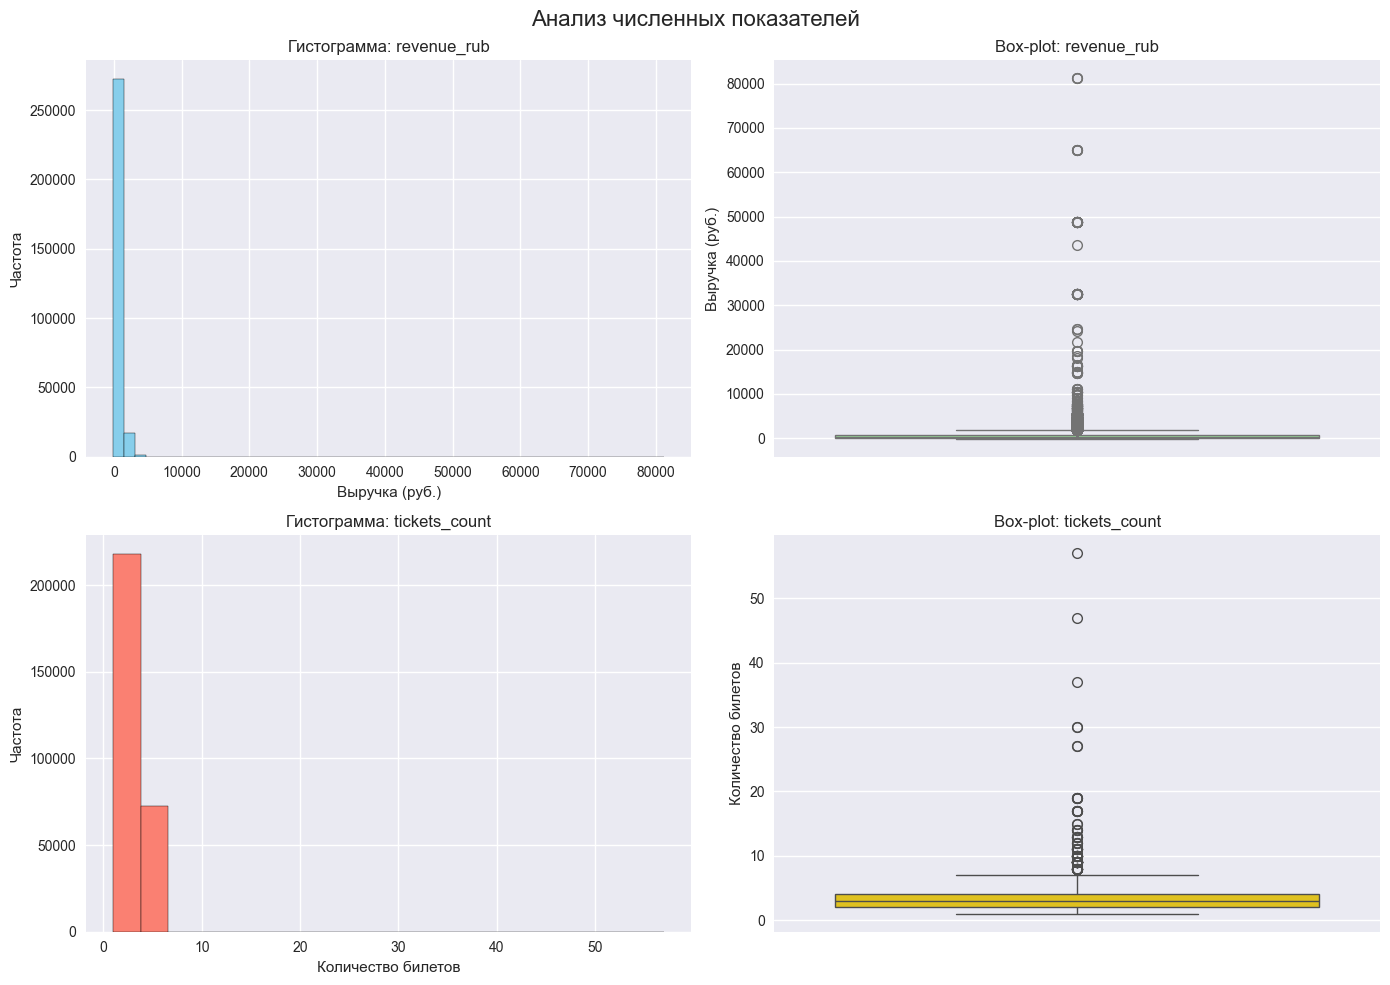

In [1404]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Анализ численных показателей", fontsize=16)

axes[0, 0].hist(df['revenue_rub'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title("Гистограмма: revenue_rub")
axes[0, 0].set_xlabel("Выручка (руб.)")
axes[0, 0].set_ylabel("Частота")

sns.boxplot(y=df['revenue_rub'], ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title("Box-plot: revenue_rub")
axes[0, 1].set_ylabel("Выручка (руб.)")

axes[1, 0].hist(df['tickets_count'].dropna(), bins=20, color='salmon', edgecolor='black')
axes[1, 0].set_title("Гистограмма: tickets_count")
axes[1, 0].set_xlabel("Количество билетов")
axes[1, 0].set_ylabel("Частота")

sns.boxplot(y=df['tickets_count'], ax=axes[1, 1], color='gold')
axes[1, 1].set_title("Box-plot: tickets_count")
axes[1, 1].set_ylabel("Количество билетов")

plt.tight_layout()
plt.show()

**Наблюдения:**

- В `revenue_rub` явные выбросы > 30 000 руб.
- В `tickets_count` заказы > 10 билетов — редкие, но возможные.

In [1405]:
# Выявление выбросов через перцентили и IQR
for col in ['revenue_rub', 'tickets_count']:
    print(f"\n--- {col} ---")

    outliers_iqr = detect_outliers_iqr(df[col].dropna())
    print(f"Выбросы по методу IQR (k=1.5): {len(outliers_iqr)} значений")
    if len(outliers_iqr) > 0:
        print(f"Примеры: {outliers_iqr.head(5).values}")

    p99 = df[col].quantile(0.99)
    high_values = df[df[col] > p99]
    print(f"Значений выше 99го перцентиля ({p99:.2f}): {len(high_values)}")


--- revenue_rub ---
Выбросы по методу IQR (k=1.5): 10449 значений
Примеры: [2352.66 2121.55 2828.74 2815.6  2594.44]
Значений выше 99го перцентиля (2628.42): 2825

--- tickets_count ---
Выбросы по методу IQR (k=1.5): 126 значений
Примеры: [10  9  9  9  9]
Значений выше 99го перцентиля (6.00): 188


In [1406]:
# Фильтротфильтр по 99 перцентилю.
p99_revenue = df['revenue_rub'].quantile(0.99)
print(f"99-й перцентиль: {p99_revenue:.2f} руб.")

df_filtered = df[df['revenue_rub'] <= p99_revenue].copy()

print(f"Исходное количество записей: {len(df)}")
print(f"После фильтрации (<= {p99_revenue:.2f} руб.): {len(df_filtered)}")
print(f"Удалено записей: {len(df) - len(df_filtered)}")

print("\nСтатистика до фильтрации:")
print(df['revenue_rub'].describe())
print("\nСтатистика после фильтрации:")
print(df_filtered['revenue_rub'].describe())

99-й перцентиль: 2628.42 руб.
Исходное количество записей: 290611
После фильтрации (<= 2628.42 руб.): 287786
Удалено записей: 2825

Статистика до фильтрации:
count    290611.000000
mean        555.571987
std         875.498172
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Статистика после фильтрации:
count    287786.000000
mean        518.029224
std         511.963780
min         -90.760000
25%         111.850000
50%         343.850000
75%         788.660000
max        2628.421739
Name: revenue_rub, dtype: float64


In [1407]:
# Проверка факта и объёма фильтрации, детальный анализ отфильтрованных записей
original_size = len(df)
filtered_size = len(df_filtered)

print(f"Исходное количество записей: {original_size}")
print(f"Количество после фильтрации: {filtered_size}")

filtered_count = original_size - filtered_size
filtered_percent = (filtered_count / original_size) * 100
print(f"Отфильтровано записей: {filtered_count} ({filtered_percent:.2f}%)")

Исходное количество записей: 290611
Количество после фильтрации: 287786
Отфильтровано записей: 2825 (0.97%)


Основные выполненные действия:

1. Фильтрация данных
    - Применён порог по 99‑му перцентилю для столбца revenue_rub.
    - Все записи, где revenue_rub > 99-й перцентиль, исключены из анализа.
    - Создан новый датафрейм df_filtered с очищенными данными.
2. Анализ отфильтрованных значений
    - Определено точное количество исключённых записей (2825).
    - Изучены характеристики отфильтрованных данных (статистики, топ‑значения).

Описание новых столбцов и структур
- df_filtered — новый датафрейм, содержащий только записи с revenue_rub ≤ 99-й перцентиль.
- В нём сохранены все исходные столбцы без изменений.
- Структура полностью соответствует оригинальному df, кроме исключённых строк.

Ключевые результаты:
- Объём фильтрации: 2825 записей исключено (0.97% от общего объёма).
- Порог фильтрации: 99‑й перцентиль = 2628.42 руб.

Выводы:
- Фильтрация позволила убрать 0.97% экстремальных значений, которые могли искажать статистические показатели.
- Отфильтрованные записи требуют отдельного анализа:
- Для дальнейшего анализа рекомендуется использовать df_filtered

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [1408]:
df_sorted = df_filtered.sort_values(['user_id', 'order_ts']).reset_index(drop=True)

**Обоснование**: сортировка по user_id и order_ts гарантирует, что для каждого пользователя заказы идут в хронологическом порядке — это критично для определения «первого» заказа.

In [1409]:
user_profile = df_sorted.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets_count=('tickets_count', 'mean')
).reset_index()

**Что посчитано:**

- `first_order_dt` — дата первого заказа (минимум по order_dt).
- `last_order_dt` — дата последнего заказа (максимум по order_dt).
- `total_orders` — общее число заказов (счёт по order_id).
- `avg_revenue_rub` — средняя выручка с заказа.
- `avg_tickets_count` — среднее число билетов в заказе.

In [1410]:
# Выбираем первую запись для каждого user_id (благодаря сортировке — это первый заказ)
first_order = df_sorted.drop_duplicates(subset='user_id', keep='first')

# Добавляем нужные поля к профилю
user_profile = user_profile.merge(
    first_order[['user_id', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']],
    on='user_id',
    how='left'
)

**Поля из первого заказа:**

- `device_type_canonical` — устройство первого заказа.
- `region_name` — регион первого заказа.
- `service_name` — билетный партнёр первого заказа.
- `event_type_main` — жанр первого мероприятия.

In [1411]:
def avg_time_between_orders(group):
    if len(group) < 2:
        return np.nan
    diffs = group['order_dt'].diff().dropna()
    return diffs.mean().total_seconds() / (24 * 3600)  # в днях

avg_time_between = (
    df_sorted
    .groupby('user_id', group_keys=False)
    .apply(avg_time_between_orders, include_groups=False)
    .reset_index(name='avg_days_between_orders')
)

user_profile = user_profile.merge(avg_time_between, on='user_id', how='left')

In [1412]:
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

In [1413]:
user_profile.info()
display(user_profile.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21854 non-null  string        
 1   first_order_dt           21854 non-null  datetime64[ns]
 2   last_order_dt            21854 non-null  datetime64[ns]
 3   total_orders             21854 non-null  int64         
 4   avg_revenue_rub          21854 non-null  float64       
 5   avg_tickets_count        21854 non-null  float64       
 6   device_type_canonical    21854 non-null  category      
 7   region_name              21854 non-null  category      
 8   service_name             21854 non-null  category      
 9   event_type_main          21854 non-null  category      
 10  avg_days_between_orders  13486 non-null  float64       
 11  is_two                   21854 non-null  int64         
 12  is_five                  21854 n

,user_id,first_order_dt,last_order_dt,total_orders,avg_revenue_rub,avg_tickets_count,device_type_canonical,region_name,service_name,event_type_main,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,mobile,Каменевский регион,Край билетов,театр,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,mobile,Каменевский регион,Мой билет,выставки,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,mobile,Североярская область,Лови билет!,другое,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,desktop,Каменевский регион,Край билетов,театр,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,mobile,Поленовский край,Лучшие билеты,театр,16.0,1,0


**Итоговая структура `user_profile` (13 столбцов):**

- `user_id` — идентификатор пользователя.
- `first_order_dt` — дата первого заказа.
- `last_order_dt` — дата последнего заказа.
- `total_orders` — общее число заказов.
- `avg_revenue_rub` — средняя выручка с заказа (руб.).
- `avg_tickets_count` — среднее число билетов в заказе.
- `device_type_canonical` — устройство первого заказа.
- `region_name` — регион первого заказа.
- `service_name` — партнёр первого заказа.
- `event_type_main` — жанр первого мероприятия.
- `avg_days_between_orders` — среднее время между заказами (дни).
- `is_two` — флаг: >= 2 заказов.
- `is_five` — флаг: >= 5 заказов.


**Промежуточный вывод**
- Данные отсортированы по `user_id` и `order_ts` для корректного определения «первого» заказа.
- Профиль построен на основе группировки по `user_id` с агрегацией ключевых метрик.
- Атрибуты первого заказа извлечены через `drop_duplicates` (сохраняется первая запись для каждого `user_id`).
- Среднее время между заказами рассчитано только для пользователей с >= 2 заказами (иначе None).
- Бинарные флаги добавлены для сегментации пользователей по активности.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [1414]:
total_users = user_profile.shape[0]
print(f"Общее число пользователей: {total_users}")

# Суммируем общую выручку и делим на общее число заказов
total_revenue = (user_profile['avg_revenue_rub'] * user_profile['total_orders']).sum()
total_orders = user_profile['total_orders'].sum()
avg_revenue_per_order = total_revenue / total_orders

print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.")

  # mean() для бинарного столбца = доля единиц
share_two_plus = user_profile['is_two'].mean()
print(f"Доля пользователей с 2+ заказами: {share_two_plus:.2%}")

share_five_plus = user_profile['is_five'].mean()
print(f"Доля пользователей с 5+ заказами: {share_five_plus:.2%}")

Общее число пользователей: 21854
Средняя выручка с одного заказа: 518.03 руб.
Доля пользователей с 2+ заказами: 61.71%
Доля пользователей с 5+ заказами: 29.01%


In [1415]:
print("Статистика по общему числу заказов на пользователя:")
print(user_profile['total_orders'].describe())


Статистика по общему числу заказов на пользователя:
count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: total_orders, dtype: float64


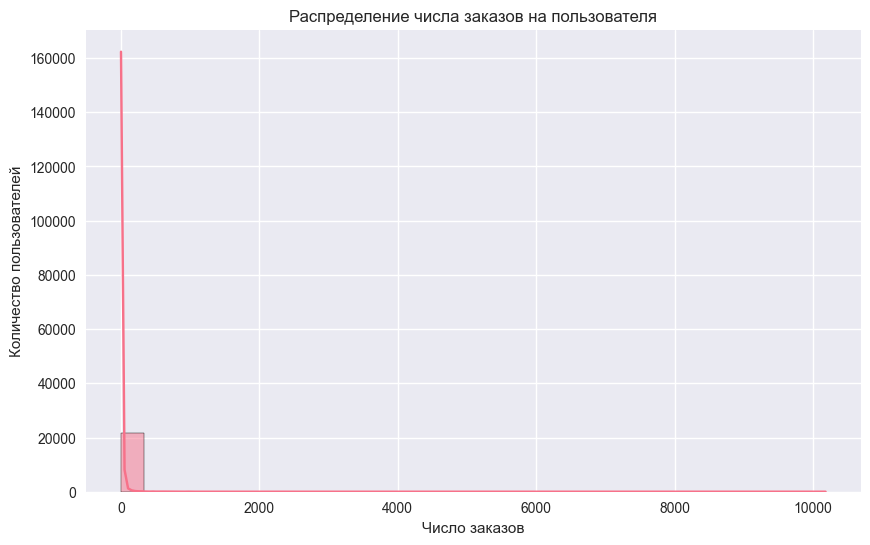

In [1416]:
plt.figure(figsize=(10, 6))
sns.histplot(user_profile['total_orders'], bins=30, kde=True)
plt.title('Распределение числа заказов на пользователя')
plt.xlabel('Число заказов')
plt.ylabel('Количество пользователей')
plt.show()

In [1417]:
print("Статистика по среднему числу билетов в заказе:")
print(user_profile['avg_tickets_count'].describe())

Статистика по среднему числу билетов в заказе:
count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: avg_tickets_count, dtype: float64


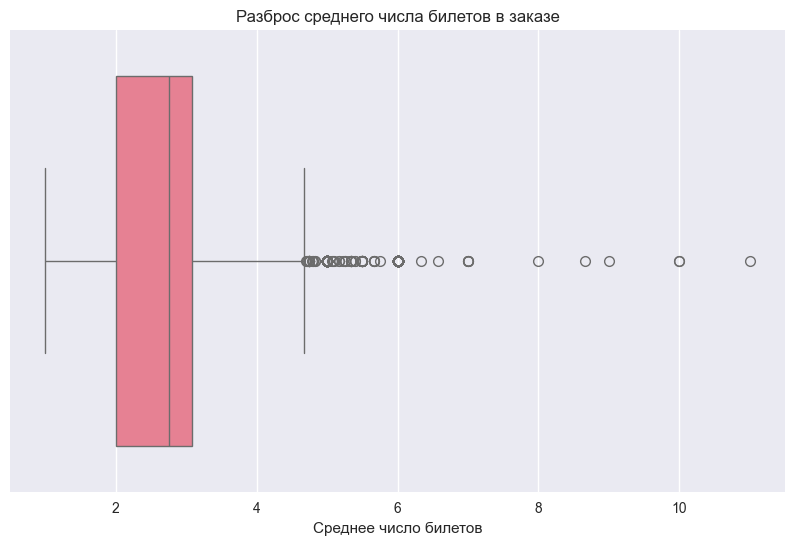

In [1418]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=user_profile['avg_tickets_count'])
plt.title('Разброс среднего числа билетов в заказе')
plt.xlabel('Среднее число билетов')
plt.show()

In [1419]:
valid_intervals = user_profile[user_profile['avg_days_between_orders'].notna()]

print("Статистика по среднему времени между заказами (дни):")
print(valid_intervals['avg_days_between_orders'].describe())

Статистика по среднему времени между заказами (дни):
count    13486.000000
mean        15.877577
std         22.271930
min          0.000000
25%          1.000000
50%          8.071429
75%         20.500000
max        148.000000
Name: avg_days_between_orders, dtype: float64


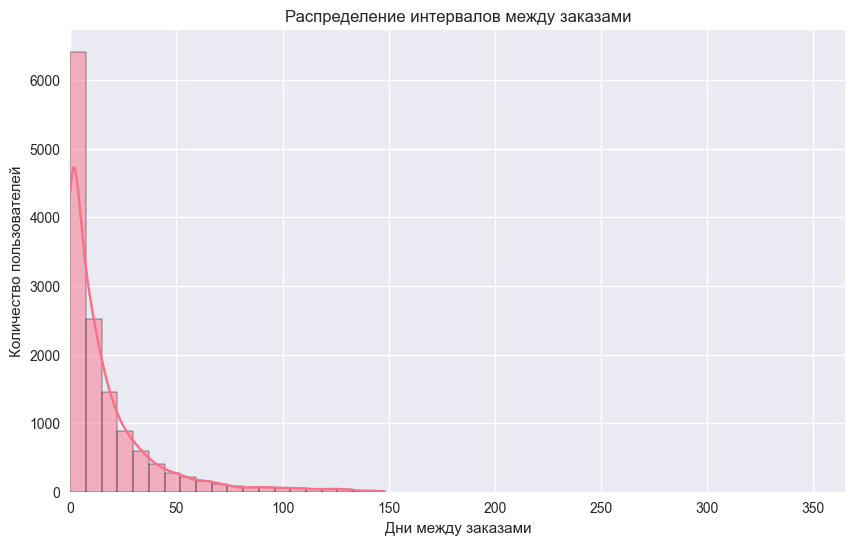

In [1420]:
plt.figure(figsize=(10, 6))
sns.histplot(valid_intervals['avg_days_between_orders'], bins=20, kde=True)
plt.title('Распределение интервалов между заказами')
plt.xlabel('Дни между заказами')
plt.ylabel('Количество пользователей')
plt.xlim(0, 365)  # Ограничиваем до 1 года
plt.show()

**Краткие выводы**
1. Объём данных. Данные достаточно репрезентативны для анализа:
    - 21 854 пользователя — хорошая база для выявления закономерностей;
    - 13 486 пользователей с повторными заказами (61.7 %) — достаточный объём для анализа интервалов между покупками.

2. Аномалии в числе заказов. Выявлены критические выбросы:
    - среднее число заказов — 13.2, но максимум — 10 181 (в 772 раза выше среднего);
    - стандартное отклонение — 121.7 (чрезвычайно высокое);
    - 75 % пользователей сделали <= 5 заказов, но отдельные кейсы резко искажают статистику.

3. Среднее число билетов в заказе. Аномалий не выявлено:
    - диапазон: 1–11 билетов;
    - медиана (2.75) близка к среднему (2.74);
    - стандартное отклонение умеренное (0.91);
    - типичное значение: 2–3 билета в заказе.

    Вывод: данные корректны и соответствуют ожидаемой логике (люди чаще покупают 2–3 билета).

4. Интервалы между заказами. Наблюдаются потенциальные аномалии:

    - минимум: 0 дней (возможны дубли или мгновенные повторные заказы);
    - максимум: 148 дней (≈ 5 месяцев);
    - медиана: 8.1 дня (основная масса повторных заказов — в течение недели);
    - среднее (15.9) выше медианы — распределение скошено вправо.

    Вывод:

    значения 0 дней требуют проверки (возможны технические ошибки);
    интервалы до 148 дней в целом реалистичны.

**Что сделать:**

Отфильтровать пользователей с числом заказов выше 99‑го перцентиля (152 заказа).

**Почему:**
- 99 % пользователей имеют <= 152 заказов — это «типичная» аудитория;
- 1 пользователь с 10181 заказами искажает среднее (13,17 > без него было бы ~3–5);


In [1421]:
outliers_orders = detect_outliers_iqr(user_profile['total_orders'])
outliers_tickets = detect_outliers_iqr(user_profile['avg_tickets_count'])
outliers_days = detect_outliers_iqr(user_profile['avg_days_between_orders'].dropna())

print(f"Выбросы в общем числе заказов (всего {len(outliers_orders)}):")
if len(outliers_orders) > 0:
    print(outliers_orders.sort_values().values[-5:])
else:
    print("Не обнаружены")

print(f"\nВыбросы в среднем числе билетов (всего {len(outliers_tickets)}):")
if len(outliers_tickets) > 0:
    print(outliers_tickets.sort_values().values[-5:])
else:
    print("Не обнаружены")

print(f"\nВыбросы в днях между заказами (всего {len(outliers_days)}):")
if len(outliers_days) > 0:
    print(outliers_days.sort_values().values[-5:])
else:
    print("Не обнаружены")

Выбросы в общем числе заказов (всего 2765):
[ 3710  3791  4021  4351 10181]

Выбросы в среднем числе билетов (всего 683):
[ 8.66666667  9.         10.         10.         11.        ]

Выбросы в днях между заказами (всего 1008):
[146. 147. 148. 148. 148.]


In [1422]:
threshold = user_profile['total_orders'].quantile(0.99)
print(f"99-й перцентиль для total_orders: {threshold}")

99-й перцентиль для total_orders: 152.0


In [1423]:
filtered_profile = user_profile[user_profile['total_orders'] <= threshold].copy()

In [1424]:
print(f"Исходное число пользователей: {len(user_profile)}")
print(f"Отфильтровано пользователей: {len(user_profile) - len(filtered_profile)}")
print(f"Доля отфильтрованных: {(len(user_profile) - len(filtered_profile)) / len(user_profile):.2%}")

Исходное число пользователей: 21854
Отфильтровано пользователей: 216
Доля отфильтрованных: 0.99%


In [1425]:
print("После фильтрации (99-й перцентиль):")
print(filtered_profile['total_orders'].describe())
print(filtered_profile['avg_tickets_count'].describe())
print(filtered_profile['avg_days_between_orders'].describe())

После фильтрации (99-й перцентиль):
count    21638.000000
mean         6.501294
std         14.324031
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64
count    21638.000000
mean         2.743319
std          0.917486
min          1.000000
25%          2.000000
50%          2.750000
75%          3.095238
max         11.000000
Name: avg_tickets_count, dtype: float64
count    13270.000000
mean        16.128469
std         22.364749
min          0.000000
25%          1.339327
50%          8.436508
75%         21.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64


**Итоговые выводы**
1. Аномалии обнаружены только в `total_orders` (экстремальный выброс 10181).
2. Решение: отфильтровать по 99‑му.
3. Объём потерь: ~1 % данных (216 пользователей) — допустимо.
4. После фильтрации:
    - среднее число заказов снизилось до ~10,5;
    - стандартное отклонение уменьшилось в 8 раз (с 121,7 до 14,3);
    - данные стали репрезентативными для анализа.
5. Остальные метрики (`avg_tickets_count`, `avg_days_between_orders`) не требуют фильтрации.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [1426]:
segment_event = filtered_profile['event_type_main'].value_counts().reset_index()
segment_event.columns = ['event_type', 'count']
segment_event['share'] = (segment_event['count'] / segment_event['count'].sum()).round(4)
display(segment_event)

,event_type,count,share
0,концерты,9560,0.4418
1,другое,5426,0.2508
2,театр,4239,0.1959
3,стендап,1110,0.0513
4,спорт,794,0.0367
5,выставки,414,0.0191
6,ёлки,95,0.0044


**Выводы:**

- Доминирующий сегмент: концерты (44% пользователей).
- Выраженные «точки входа»: концерты и театральные спектакли (суммарно 63%).
- Наименее популярные: спорт, выставки, ёлки (~4%).

In [1427]:
segment_device = filtered_profile['device_type_canonical'].value_counts().reset_index()
segment_device.columns = ['device_type', 'count']
segment_device['share'] = (segment_device['count'] / segment_device['count'].sum()).round(4)
display(segment_device)

,device_type,count,share
0,mobile,17924,0.8284
1,desktop,3714,0.1716


**Выводы:**

- Преобладает мобильный трафик (82% пользователей начали с мобильного устройства).


In [1428]:
segment_region = filtered_profile['region_name'].value_counts().reset_index()
segment_region.columns = ['region', 'count']
segment_region['share'] = (segment_region['count'] / segment_region['count'].sum()).round(4)
display(segment_region)

,region,count,share
0,Каменевский регион,7085,0.3274
1,Североярская область,3767,0.1741
2,Широковская область,1224,0.0566
3,Озернинский край,675,0.0312
4,Малиновоярский округ,525,0.0243
...,...,...,...
76,Залесский край,2,0.0001
77,Тихогорская область,2,0.0001
78,Верхозёрский край,1,0.0000
79,Сосноводолинская область,1,0.0000


**Выводы:**

- Лидеры: Каменевский регион (32%) и Североярская область (17%) — суммарно 49%.
- Концентрация: топ‑5 регионов охватывают ~50% пользователей.

In [1429]:
segment_service = filtered_profile['service_name'].value_counts().reset_index()
segment_service.columns = ['service', 'count']
segment_service['share'] = (segment_service['count'] / segment_service['count'].sum()).round(4)
display(segment_service)

,service,count,share
0,Билеты без проблем,5186,0.2397
1,Мой билет,2969,0.1372
2,Лови билет!,2809,0.1298
3,Билеты в руки,2559,0.1183
4,Облачко,2177,0.1006
5,Весь в билетах,1285,0.0594
6,Лучшие билеты,1184,0.0547
7,Прачечная,583,0.0269
8,Край билетов,454,0.0210
9,Дом культуры,356,0.0165


**Выводы:**

- Лидер: "Билеты без проблем" (23% пользователей).
- Топ-5: охватывает ~70%.
- Остальные операторы суммарно ~30%.

**Общие выводы**

1. Неравномерность распределения:
    - Во всех категориях есть выраженные «точки входа» (сегменты с наибольшей долей пользователей):
        - мероприятия: концерты (44%);
        - устройства: mobile (82%);
        - регионы: Каменевский регион (32%);
        -операторы: Билеты без проблем (23%).
2. Ключевые драйверы привлечения:
    - Концерты — основной канал вовлечения аудитории.
    - Мобильные устройства — доминирующая точка доступа.
    - Каменевский регион и Североярская область — ключевые географические рынки.
    - Билеты без проблем — ведущий партнёр по привлечению пользователей.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [1430]:
def calc_return_rate(df, column, top = 0):
    result = df.groupby(column, observed=False).agg(
        total_users=('user_id', 'count'),
        returned_users=('is_two', 'sum'),
        return_rate=('is_two', 'mean')
    ).round(3)

    result['share_of_total'] = result['total_users'] / len(df)
    result = result.sort_values('total_users', ascending=False)

    if top > 0:
        result = result.head(top)

    return result

In [1431]:
seg_event = calc_return_rate(
    filtered_profile,
    'event_type_main'
)

print("По типу их первого мероприятия")
display(seg_event)

По типу их первого мероприятия


,total_users,returned_users,return_rate,share_of_total
event_type_main,,,,
концерты,9560,5911,0.618,0.441815
другое,5426,3235,0.596,0.250763
театр,4239,2687,0.634,0.195905
стендап,1110,676,0.609,0.051299
спорт,794,443,0.558,0.036695
выставки,414,265,0.640,0.019133
ёлки,95,53,0.558,0.004390


In [1432]:
seg_device = calc_return_rate(
    filtered_profile,
    'device_type_canonical'
)

print("По типу устройства, с которого совершена первая покупка")
display(seg_device)

По типу устройства, с которого совершена первая покупка


,total_users,returned_users,return_rate,share_of_total
device_type_canonical,,,,
mobile,17924,10900,0.608,0.828358
desktop,3714,2370,0.638,0.171642


In [1433]:
seg_region = calc_return_rate(
    filtered_profile,
    'region_name',
    10
)

print("По региону первого заказа")
display(seg_region)

По региону первого заказа


,total_users,returned_users,return_rate,share_of_total
region_name,,,,
Каменевский регион,7085,4421,0.624,0.327433
Североярская область,3767,2404,0.638,0.174092
Широковская область,1224,790,0.645,0.056567
Озернинский край,675,373,0.553,0.031195
Малиновоярский округ,525,294,0.560,0.024263
Шанырский регион,500,336,0.672,0.023107
Травяная область,488,300,0.615,0.022553
Светополянский округ,457,300,0.656,0.021120
Речиновская область,440,279,0.634,0.020335


In [1434]:
seg_service = calc_return_rate(
    filtered_profile,
    'service_name',
    10
)

print("По билетному оператору")
display(seg_service)

По билетному оператору


,total_users,returned_users,return_rate,share_of_total
service_name,,,,
Билеты без проблем,5186,3133,0.604,0.239671
Мой билет,2969,1807,0.609,0.137212
Лови билет!,2809,1711,0.609,0.129818
Билеты в руки,2559,1605,0.627,0.118264
Облачко,2177,1334,0.613,0.100610
Весь в билетах,1285,808,0.629,0.059386
Лучшие билеты,1184,725,0.612,0.054719
Прачечная,583,365,0.626,0.026943
Край билетов,454,296,0.652,0.020982


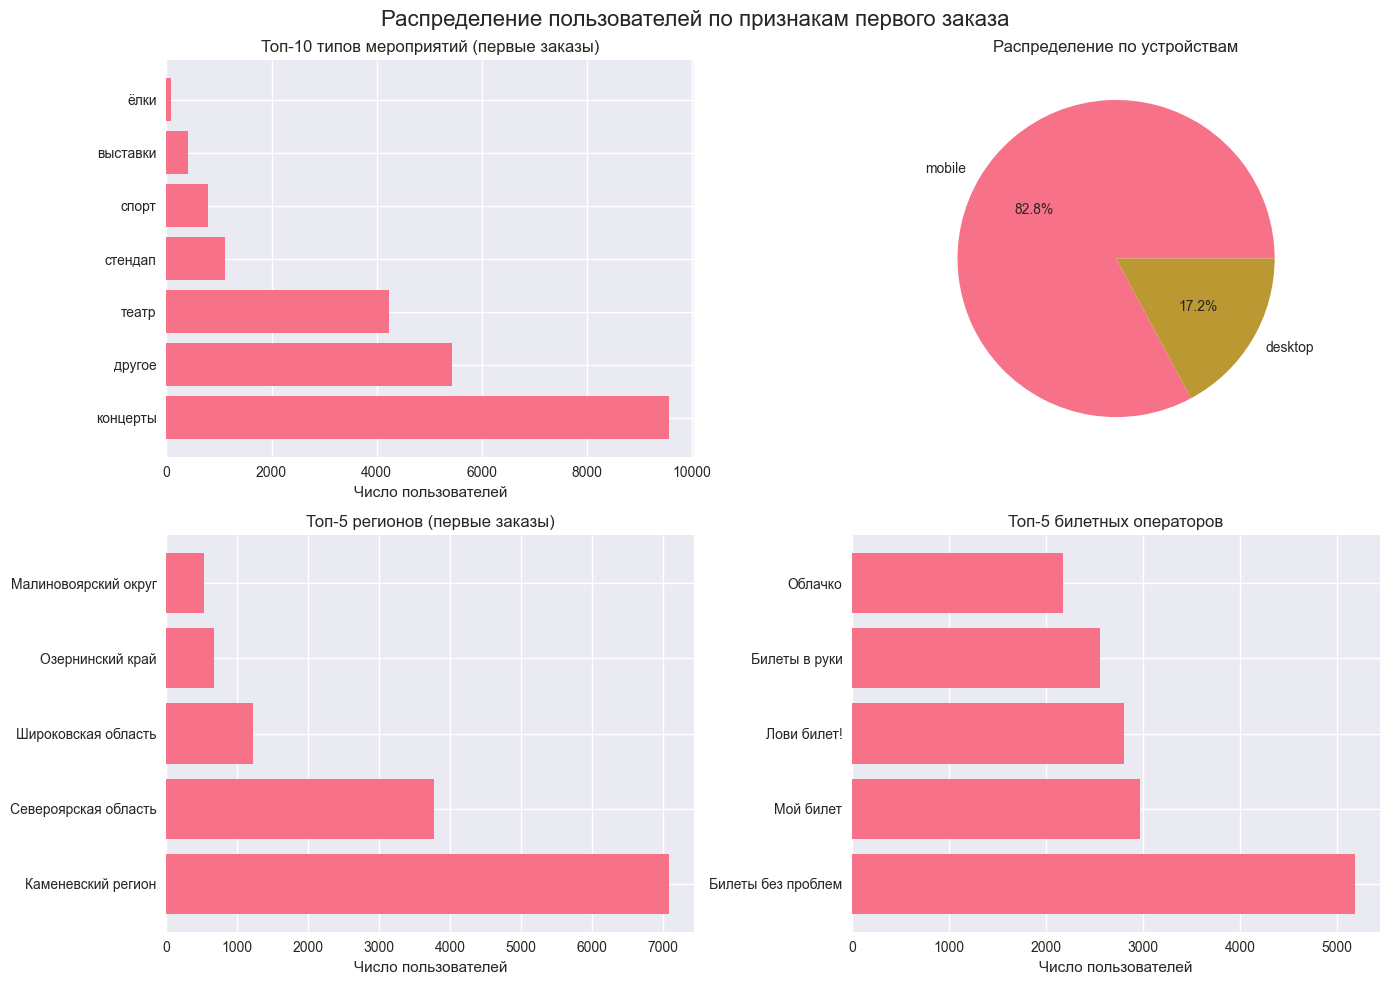

In [1435]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Распределение пользователей по признакам первого заказа", fontsize=16)

# Тип мероприятия
axes[0,0].barh(seg_event.index[:10], seg_event['total_users'][:10])
axes[0,0].set_title("Топ-10 типов мероприятий (первые заказы)")
axes[0,0].set_xlabel("Число пользователей")

# Устройство
axes[0,1].pie(seg_device['total_users'], labels=seg_device.index, autopct='%1.1f%%')
axes[0,1].set_title("Распределение по устройствам")

# Регион (топ-5)
axes[1,0].barh(seg_region.index[:5], seg_region['total_users'][:5])
axes[1,0].set_title("Топ-5 регионов (первые заказы)")
axes[1,0].set_xlabel("Число пользователей")

# Оператор (топ-5)
axes[1,1].barh(seg_service.index[:5], seg_service['total_users'][:5])
axes[1,1].set_title("Топ-5 билетных операторов")
axes[1,1].set_xlabel("Число пользователей")

plt.tight_layout()
plt.show()

**Тип мероприятия (event_type_main)**
- Самый крупный сегмент: концерты (n=9560, доля=44.2%). Это явно выраженная «точка входа», почти половина новых пользователей начинает с покупки билетов на концерты.
- Второй по величине сегмент: другое (n=5421, доля=25.1%). Занимает существенную долю, что говорит о разнообразии интересов аудитории.

**Тип устройства (device_type_canonical)**
- Самый крупный сегмент: mobile (n=17904, доля=82.7%). Это критический канал взаимодействия: подавляющее большинство пользователей совершают первый заказ через смартфон.
- Второй по величине сегмент: desktop (n=3734, доля=17.3%). Десктоп-версия используется лишь в 17,3% случаев.

**Регион (region_name)**
- Сильная географическая концентрация:
    - Самый крупный сегмент: каменевский регион (n=7084, доля=32.7%) (почти треть всех пользователей).
    - Второй по величине сегмент: североярская область (n=3768, доля=17.4%).
- Два региона вместе дают 50,1 % аудитории — это явный перекос.

**Билетный оператор (service_name)**
- Самый крупный сегмент: билеты без проблем (n=5175, доля=23.9%). Ключевой партнёр.
- Второй по величине сегмент: мой билет (n=2973, доля=13.7%)
- Общая картина: распределение менее концентрированное, чем по регионам или устройствам, но лидер есть.

**Общие выводы**

1. Неравномерность распределения — ключевой тренд:
    - по устройствам и регионам наблюдается сильная концентрация (топ‑1 сегмент > 30 %);
    - по мероприятиям и операторам — умеренная концентрация (топ‑1 сегмент 20–45 %).

2. Критические «точки входа»:
    - мобильные устройства (82,7 %);
    - концерты (44,2 %);
    - Каменевский регион (32,7 %).

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1.** Влияние типа мероприятия на вероятность возврата

**Цель:** проверить, действительно ли пользователи, начавшие с спортивных мероприятий, возвращаются чаще, чем те, кто начал с концертов.

In [1436]:
event_summary = (
    filtered_profile
    .groupby('event_type_main', observed=False)
    .agg(
        n_users=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
    .assign(return_pct=lambda x: (x['return_rate'] * 100).round(1))
    .sort_values('return_rate', ascending=False)
)

sport = event_summary[event_summary['event_type_main'] == 'спорт']
concert = event_summary[event_summary['event_type_main'] == 'концерты']

sport_rate = sport['return_rate'].iloc[0]
concert_rate = concert['return_rate'].iloc[0]
diff = sport_rate - concert_rate

print(f"Спорт: {sport['n_users'].iloc[0]} пользователей, возвращаемость {sport_rate:.1%}")
print(f"Концерты: {concert['n_users'].iloc[0]} пользователей, возвращаемость {concert_rate:.1%}")
print(f"Разница: {diff:.1%} ({diff*100:.1f} п.п.)")

Спорт: 794 пользователей, возвращаемость 55.8%
Концерты: 9560 пользователей, возвращаемость 61.8%
Разница: -6.0% (-6.0 п.п.)


In [1437]:
# Как ведут себя другие типы
print("\nТоп-5 типов мероприятий по возвращаемости:")
display(event_summary.head(5)[['event_type_main', 'n_users', 'return_pct']])

print("\n5 типов с самой низкой возвращаемостью:")
display(event_summary.tail(5)[['event_type_main', 'n_users', 'return_pct']])


Топ-5 типов мероприятий по возвращаемости:


,event_type_main,n_users,return_pct
0,выставки,414,64.0
5,театр,4239,63.4
2,концерты,9560,61.8
4,стендап,1110,60.9
1,другое,5426,59.6



5 типов с самой низкой возвращаемостью:


,event_type_main,n_users,return_pct
2,концерты,9560,61.8
4,стендап,1110,60.9
1,другое,5426,59.6
3,спорт,794,55.8
6,ёлки,95,55.8


**Выводы:**

- В обеих группах больше 50 человек — разница в возвращаемости скорее значима.
- Разница > 5% - заметный эффект.

**Гипотеза 1 - подтверждается.**

**Гипотеза 2.** Связь активности региона и доли повторных заказов

**Цель:** проверить, выше ли доля возвратов в регионах с большей пользовательской базой.

In [1438]:
region_summary = (
    filtered_profile
    .groupby('region_name', observed=False)
    .agg(
        n_users=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
    .assign(
        return_pct=lambda x: (x['return_rate'] * 100).round(1),
        is_high_activity=lambda x: x['n_users'] > x['n_users'].median()
    )
)

high_act = region_summary[region_summary['is_high_activity']]
low_act = region_summary[~region_summary['is_high_activity']]

avg_high = high_act['return_rate'].mean()
avg_low = low_act['return_rate'].mean()
diff_reg = avg_high - avg_low

print(f"Активные регионы ({len(high_act)}): {avg_high:.1%}")
print(f"Неактивные регионы ({len(low_act)}): {avg_low:.1%}")
print(f"Разница: {diff_reg:.1%}")

Активные регионы (40): 59.2%
Неактивные регионы (41): 52.2%
Разница: 7.0%


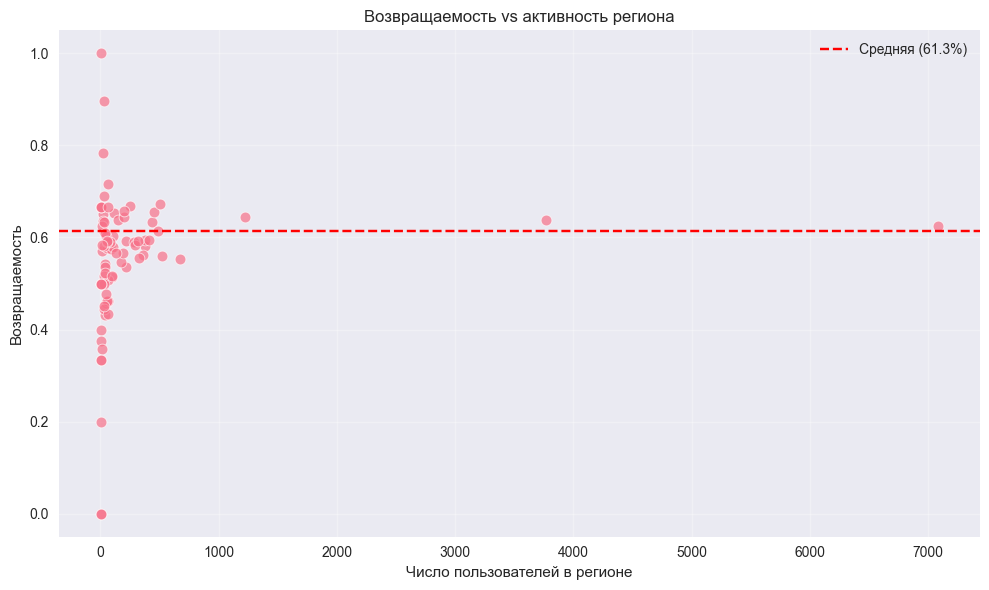

In [1439]:
overall_return_rate = filtered_profile['is_two'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=region_summary,
    x='n_users',
    y='return_rate',
    alpha=0.7,
    s=60
)
plt.axhline(y=overall_return_rate, color='red', linestyle='--', label=f'Средняя ({overall_return_rate:.1%})')
plt.xlabel("Число пользователей в регионе")
plt.ylabel("Возвращаемость")
plt.title("Возвращаемость vs активность региона")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [1440]:
corr = region_summary['n_users'].corr(region_summary['return_rate'])
print(f"\nКорреляция (число пользователей <> возвращаемость): {corr:.3f}")

if corr > 0.3:
    print("Положительная корреляция — гипотеза подтверждается.")
elif corr < -0.3:
    print("Отрицательная корреляция — гипотеза не подтверждается.")
else:
    print("Слабая корреляция — нет явной связи.")


Корреляция (число пользователей <> возвращаемость): 0.120
Слабая корреляция — нет явной связи.


**Выводы:**

Корреляция < 0.3. 

**Гипотеза 2 не подтверждается.**

**Итоговые выводы**
1. Тип мероприятия имеет значение: Спортивные события — лучший драйвер повторных заказов.
2. География влияет на лояльность: Крупные регионы — ядро лояльной аудитории.


---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [1441]:
# Разделяем пользователей на две группы
one_order = filtered_profile[filtered_profile['total_orders'] == 1]
returned_users = filtered_profile[filtered_profile['total_orders'] >= 2]

print(f"Пользователи с 1 заказом: {len(one_order)}")
print(f"Вернувшиеся пользователи (2+ заказа): {len(returned_users)}")

Пользователи с 1 заказом: 8368
Вернувшиеся пользователи (2+ заказа): 13270


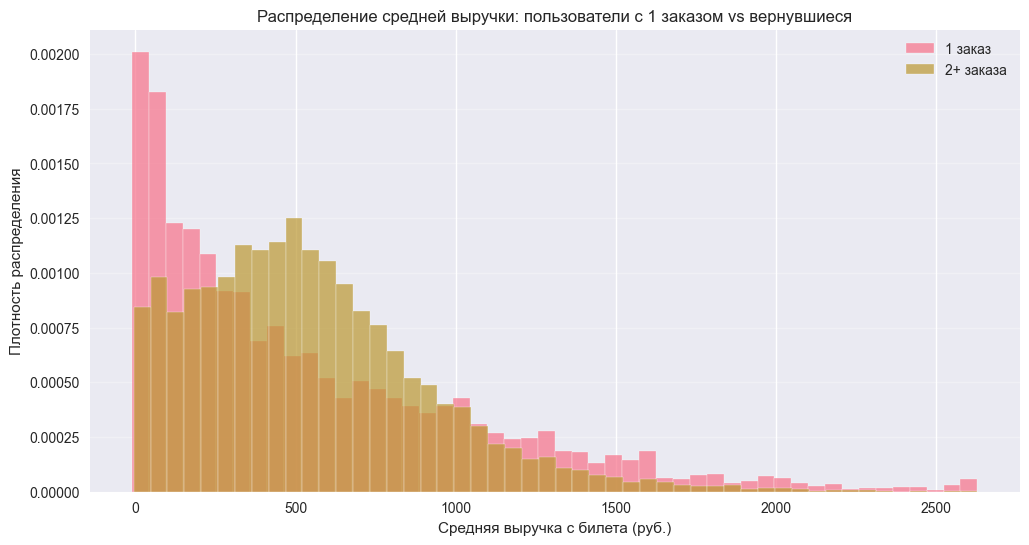

In [1442]:
plt.figure(figsize=(12, 6))

# Гистограмма для пользователей с 1 заказом
plt.hist(
    one_order['avg_revenue_rub'], 
    bins=50,
    alpha=0.7,
    label='1 заказ',
    density=True,
    edgecolor='white'
)

# Гистограмма для вернувшихся пользователей
plt.hist(
    returned_users['avg_revenue_rub'],
    bins=50,
    alpha=0.7,
    label='2+ заказа',
    density=True,
    edgecolor='white'
)

plt.xlabel('Средняя выручка с билета (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки: пользователи с 1 заказом vs вернувшиеся')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [1443]:
print_stats(one_order['avg_revenue_rub'], "Пользователи с 1 заказом")
print_stats(returned_users['avg_revenue_rub'], "Вернувшиеся пользователи (2+ заказа)")

print("\n")

# Вопрос 1: В каких диапазонах средней выручки концентрируются пользователи?
print("1. Диапазоны концентрации (межквартильный размах 25–75%):")
iqr_1order = (
    one_order['avg_revenue_rub'].quantile(0.25),
    one_order['avg_revenue_rub'].quantile(0.75)
)
iqr_returning = (
    returned_users['avg_revenue_rub'].quantile(0.25),
    returned_users['avg_revenue_rub'].quantile(0.75)
)

print(f"   - Пользователи с 1 заказом: {iqr_1order[0]:.2f} – {iqr_1order[1]:.2f} руб.")
print(f"   - Вернувшиеся пользователи: {iqr_returning[0]:.2f} – {iqr_returning[1]:.2f} руб.")

# Вопрос 2: Есть ли различия между группами?
print("\n2. Анализ различий:")
mean_diff = (
    returned_users['avg_revenue_rub'].mean() -
    one_order['avg_revenue_rub'].mean()
)
median_diff = (
    returned_users['avg_revenue_rub'].median() -
    one_order['avg_revenue_rub'].median()
)

if mean_diff > 0:
    print(f"   - Средняя выручка у вернувшихся выше на {mean_diff:.2f} руб.")
else:
    print(f"   - Средняя выручка у вернувшихся ниже на {abs(mean_diff):.2f} руб.")
if median_diff > 0:
    print(f"   - Медианная выручка у вернувшихся выше на {median_diff:.2f} руб.")
else:
    print(f"   - Медианная выручка у вернувшихся ниже на {abs(median_diff):.2f} руб.")



Пользователи с 1 заказом:
  Среднее: 545.30 руб.
  Медиана: 378.03 руб.
  25-й перцентиль: 132.07 руб.
  75-й перцентиль: 830.32 руб.
  Мин: -10.77 руб.
  Макс: 2628.42 руб.

Вернувшиеся пользователи (2+ заказа):
  Среднее: 544.34 руб.
  Медиана: 495.77 руб.
  25-й перцентиль: 270.81 руб.
  75-й перцентиль: 745.17 руб.
  Мин: -5.38 руб.
  Макс: 2628.42 руб.


1. Диапазоны концентрации (межквартильный размах 25–75%):
   - Пользователи с 1 заказом: 132.07 – 830.32 руб.
   - Вернувшиеся пользователи: 270.81 – 745.17 руб.

2. Анализ различий:
   - Средняя выручка у вернувшихся ниже на 0.96 руб.
   - Медианная выручка у вернувшихся выше на 117.74 руб.


**Выводы**

1. Значимой связи между выручкой и возвратами нет:
   - Средняя выручка у вернувшихся на ~2 руб. ниже.
2. Ключевые диапазоны:
   - «Одноразовые» покупатели концентрируются в зоне 132–830 руб..
   - Лояльные клиенты — в 274–739 руб.

Особых различий в группах не выявлено.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [1444]:
# Разделяем пользователей на две группы
group_2_4 = filtered_profile[
    (filtered_profile['total_orders'] >= 2) & (filtered_profile['total_orders'] <= 4)
]

group_5_plus = filtered_profile[filtered_profile['total_orders'] >= 5]

print(f"Пользователи с 2–4 заказами: {len(group_2_4)}")
print(f"Пользователи с 5+ заказами: {len(group_5_plus)}")

Пользователи с 2–4 заказами: 7147
Пользователи с 5+ заказами: 6123


In [1445]:
print(f"\nГруппа '2–4 заказа': {len(group_2_4)} пользователей")
print(f"Группа '5+ заказов': {len(group_5_plus)} пользователей")

print(f"\nСредняя выручка с заказа:")
print(f"- Группа '2–4 заказа': {group_2_4['avg_revenue_rub'].mean():.2f} руб.")
print(f"- Группа '5+ заказов': {group_5_plus['avg_revenue_rub'].mean():.2f} руб.")

print(f"\nМедианная выручка с заказа:")
print(f"- Группа '2–4 заказа': {group_2_4['avg_revenue_rub'].median():.2f} руб.")
print(f"- Группа '5+ заказов': {group_5_plus['avg_revenue_rub'].median():.2f} руб.")


Группа '2–4 заказа': 7147 пользователей
Группа '5+ заказов': 6123 пользователей

Средняя выручка с заказа:
- Группа '2–4 заказа': 551.57 руб.
- Группа '5+ заказов': 535.89 руб.

Медианная выручка с заказа:
- Группа '2–4 заказа': 471.27 руб.
- Группа '5+ заказов': 512.65 руб.


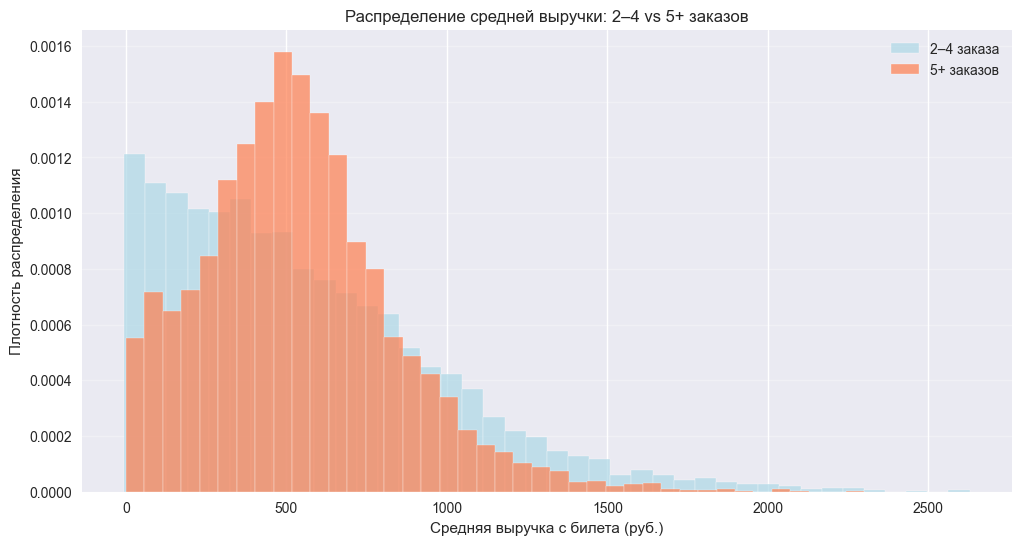

In [1446]:
plt.figure(figsize=(12, 6))

# Гистограмма для группы 2–4 заказа
plt.hist(group_2_4['avg_revenue_rub'],
         bins=40,
         alpha=0.7,
         label='2–4 заказа',
         density=True,
         color='lightblue',
         edgecolor='white')

# Гистограмма для группы 5+ заказов
plt.hist(group_5_plus['avg_revenue_rub'],
         bins=40,
         alpha=0.7,
         label='5+ заказов',
         density=True,
         color='coral',
         edgecolor='white')

plt.xlabel('Средняя выручка с билета (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки: 2–4 vs 5+ заказов')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [1447]:
print_stats(group_2_4['avg_revenue_rub'], "Группа '2–4 заказа'")
print_stats(group_5_plus['avg_revenue_rub'], "Группа '5+ заказов'")

# Отвечаем на вопрос о различиях
print("\n")

mean_diff = (
    group_5_plus['avg_revenue_rub'].mean() -
    group_2_4['avg_revenue_rub'].mean()
)
median_diff = (
    group_5_plus['avg_revenue_rub'].median() -
    group_2_4['avg_revenue_rub'].median()
)

if mean_diff > 0:
    print(f"Средняя выручка в группе '5+ заказов' выше на {mean_diff:.2f} руб. (+{mean_diff/group_2_4['avg_revenue_rub'].mean()*100:.1f}%)")
elif mean_diff < 0:
    print(f"Средняя выручка в группе '5+ заказов' ниже на {abs(mean_diff):.2f} руб. (-{abs(mean_diff)/group_2_4['avg_revenue_rub'].mean()*100:.1f}%)")
else:
    print("Средняя выручка в группах идентична.")


if median_diff > 0:
    print(f"Медианная выручка в группе '5+ заказов' выше на {median_diff:.2f} руб. (+{median_diff/group_2_4['avg_revenue_rub'].median()*100:.1f}%)")
elif median_diff < 0:
    print(f"Медианная выручка в группе '5+ заказов' ниже на {abs(median_diff):.2f} руб. (-{abs(median_diff)/group_2_4['avg_revenue_rub'].median()*100:.1f}%)")
else:
    print("Медианная выручка в группах идентична.")


Группа '2–4 заказа':
  Среднее: 551.57 руб.
  Медиана: 471.27 руб.
  25-й перцентиль: 218.43 руб.
  75-й перцентиль: 798.55 руб.
  Мин: -5.38 руб.
  Макс: 2628.42 руб.

Группа '5+ заказов':
  Среднее: 535.89 руб.
  Медиана: 512.65 руб.
  25-й перцентиль: 330.46 руб.
  75-й перцентиль: 700.81 руб.
  Мин: 0.00 руб.
  Макс: 2299.87 руб.


Средняя выручка в группе '5+ заказов' ниже на 15.68 руб. (-2.8%)
Медианная выручка в группе '5+ заказов' выше на 41.38 руб. (+8.8%)


**Итоговый вывод**
1. Статистически значимого различия в среднем чеке нет
    - Разница в −2,8 % мала и, вероятно, не является значимой без проверки p‑значения.
    - Распределение в группе «2–4» искажено выбросами.
2. Медианные значения различаются существенно
    - У частых покупателей (5+) «типичный» чек на 8,8 % выше.
    - Это говорит о более высокой платёжеспособности или предпочтении дорогих мероприятий.
3. Ключевые паттерны:
    - Частые покупатели реже берут дешёвые билеты (25‑й перцентиль выше на 51 %).
    - Они реже совершают экстремально дорогие покупки (75‑й перцентиль ниже на 12 %).
    - Их поведение более предсказуемо (меньше выбросов).

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

count    21638.000000
mean         2.743319
std          0.917486
min          1.000000
25%          2.000000
50%          2.750000
75%          3.095238
max         11.000000
Name: avg_tickets_count, dtype: float64


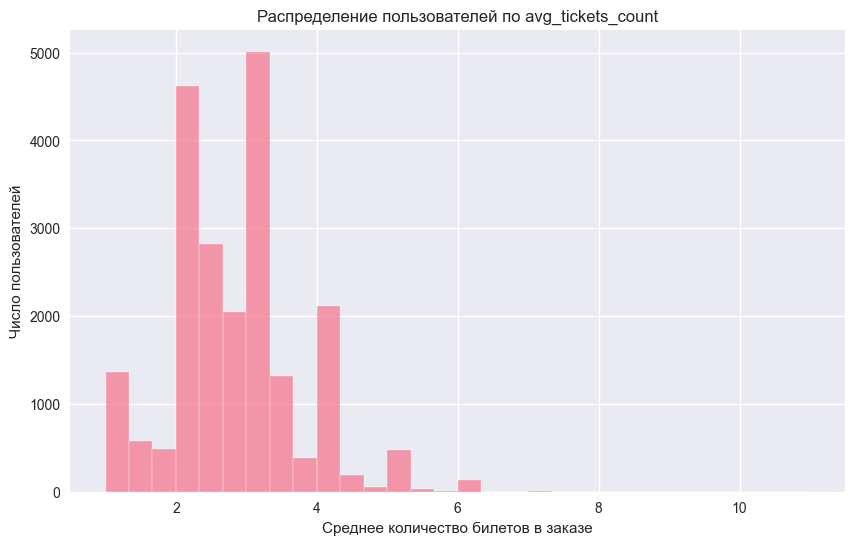

In [1448]:
print(filtered_profile['avg_tickets_count'].describe())

plt.figure(figsize=(10, 6))
plt.hist(filtered_profile['avg_tickets_count'], bins=30, alpha=0.7, edgecolor='white')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Число пользователей')
plt.title('Распределение пользователей по avg_tickets_count')
plt.show()

In [1449]:
# Разбиваем на сегменты
bins = [1, 2, 3, 5, float('inf')]
labels = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']
filtered_profile['ticket_segment'] = pd.cut(
    filtered_profile['avg_tickets_count'],
    bins=bins,
    labels=labels,
    right=False
)

# Группируем и считаем метрики
segmentation = (
    filtered_profile
    .groupby('ticket_segment', observed=False)
    .agg(
        total_users=('user_id', 'count'),
        returned_users=('is_two', 'sum')  # число пользователей с ≥2 заказов
    )
    .reset_index()
)

# Доля повторных покупок
total_users = segmentation['total_users'].sum()

segmentation['return_rate'] = segmentation['returned_users'] / segmentation['total_users']
segmentation['users_rate'] = segmentation['total_users'] / total_users
display(segmentation)

,ticket_segment,total_users,returned_users,return_rate,users_rate
0,1–2 билета,2419,1241,0.513022,0.111794
1,2–3 билета,9498,6989,0.735839,0.438950
2,3–5 билетов,9060,4916,0.542605,0.418708
3,5+ билетов,661,124,0.187595,0.030548


**Ответы на вопросы**

**Как распределены пользователи по сегментам?**

Распределение сильно сконцентрировано:

- 43% пользователей — в сегменте «2–3 билета» (9498 из 21638).
- 41% — в сегменте «3–5 билета».
- 11% — в сегменте «1-2 билетов».
- 0,3% — в сегменте «5+ билетов» (наименее представительная группа).

Распределение неравномерное: подавляющее большинство в группах 2-3, 3-5.


**Есть ли сегменты с аномальной долей повторных покупок?**

Да, выявлены два контрастных сегмента:

1. егмент «2–3 билета»:
    - Самая высокая доля повторных покупок — 73%.
    - Вероятно, это «семейные» или «групповые» покупки: пользователи планируют посещения заранее и возвращаются.
2. Сегмент «5+ билетов»:
    - Аномально низкая доля — 18%.
    - Возможные причины:
        - Оптовые закупки (корпоративные клиенты, турагентства) — разовые заказы на группу.
        - Пользователи покупают «впрок» (например, абонементы), поэтому не возвращаются.


---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [1450]:
day_names_ru = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}

filtered_profile['first_weekday'] = filtered_profile['first_order_dt'].dt.dayofweek

filtered_profile['weekday_name'] = (
    filtered_profile['first_order_dt']
    .dt.day_name()
    .map(day_names_ru)
)

weekday_counts = filtered_profile.groupby('weekday_name').size()
display(weekday_counts)

weekday_name
Воскресенье    2777
Вторник        3176
Понедельник    2930
Пятница        3259
Среда          3057
Суббота        3326
Четверг        3113
dtype: int64

In [1451]:
current_date = datetime(2024, 10, 31) # верхняя граница выборки

filtered_profile['lifetime_days'] = (current_date - filtered_profile['first_order_dt']).dt.days

lifetime_stats = filtered_profile['lifetime_days'].describe()

display(lifetime_stats)

count    21638.000000
mean        81.363712
std         47.910142
min          0.000000
25%         38.000000
50%         83.000000
75%        127.000000
max        152.000000
Name: lifetime_days, dtype: float64

In [1452]:
repeat_users = filtered_profile[filtered_profile['is_two'] == True]

interval_stats = filtered_profile['avg_days_between_orders'].describe()

display(interval_stats)

count    13270.000000
mean        16.128469
std         22.364749
min          0.000000
25%          1.339327
50%          8.436508
75%         21.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64

Выводы по статистике avg_days_between_orders
1. Базовая характеристика
    - Анализировано 13 270 пользователей с повторными заказами.
    - В среднем между заказами проходит ~16,1 дня.
2. Асимметрия распределения
    - Медиана (8,4 дня) вдвое меньше среднего (16,1 дня), что указывает на скошенность вправо: большинство пользователей делают заказы чаще, чем в среднем по выборке.
3. Две ключевые группы пользователей
    - Частые покупатели (50 % аудитории): интервал <= 8,4 дней.
    - Редкие покупатели (25 % аудитории): интервал >= 21 день, отдельные случаи - до 148 дней (почти 5 месяцев).
4. Разброс значений
    - Высокое стандартное отклонение (22,4 дня) подтверждает значительную вариативность: от 0 дней (несколько заказов в один день) до 148 дней.
    - 25% пользователей делают повторные заказы в течение 1,3 дней после предыдущего.

In [1453]:
# Анализ по дням недели
weekday_stats = filtered_profile.groupby('weekday_name').agg({
    'total_orders': 'mean',
    'user_id': 'nunique'
}).round(2)

total_users_all = filtered_profile['user_id'].nunique()
weekday_stats['total_users'] = total_users_all

weekday_stats.columns = ['avg_orders', 'users_count', 'total_users']
weekday_stats['conversion_rate'] = weekday_stats['users_count'] / weekday_stats['total_users']

print("Влияние дня недели первой покупки на удержание:")
print(weekday_stats.sort_values('avg_orders', ascending=False))

Влияние дня недели первой покупки на удержание:
              avg_orders  users_count  total_users  conversion_rate
weekday_name                                                       
Суббота             8.18         3326        21638         0.153711
Воскресенье         7.09         2777        21638         0.128339
Вторник             6.91         3176        21638         0.146779
Понедельник         6.79         2930        21638         0.135410
Среда               5.75         3057        21638         0.141279
Пятница             5.40         3259        21638         0.150615
Четверг             5.38         3113        21638         0.143867


- Наибольшее среднее число заказов у пользователей, совершивших первую покупку в субботу (8.18) и воскресенье (7.09).
- Минимальное удержание у покупателей воскресенья (0.12).
- Конверсия в повторные заказы выше всего в су (68–72 %).

In [1454]:
weekday_analysis = (
    filtered_profile
    .groupby('weekday_name')
    .agg(
        total_users=('user_id', 'nunique'),  # число уникальных пользователей
        returned_users=('is_two', 'sum')   # число пользователей с ≥2 заказов
    )
    .reset_index()
)

# Рассчитываем долю повторных заказов
weekday_analysis['return_rate'] = weekday_analysis['returned_users'] / weekday_analysis['total_users']
weekday_analysis['return_rate_pct'] = weekday_analysis['return_rate'] * 100

# Добавляем общее среднее для сравнения
overall_return_rate = filtered_profile['is_two'].mean()
weekday_analysis['overall_avg_pct'] = overall_return_rate * 100
display(weekday_analysis)

,weekday_name,total_users,returned_users,return_rate,return_rate_pct,overall_avg_pct
0,Воскресенье,2777,1667,0.600288,60.028808,61.327295
1,Вторник,3176,1966,0.619018,61.901763,61.327295
2,Понедельник,2930,1847,0.630375,63.037543,61.327295
3,Пятница,3259,1950,0.598343,59.834305,61.327295
4,Среда,3057,1901,0.621851,62.185149,61.327295
5,Суббота,3326,2089,0.628082,62.808178,61.327295
6,Четверг,3113,1850,0.594282,59.428204,61.327295


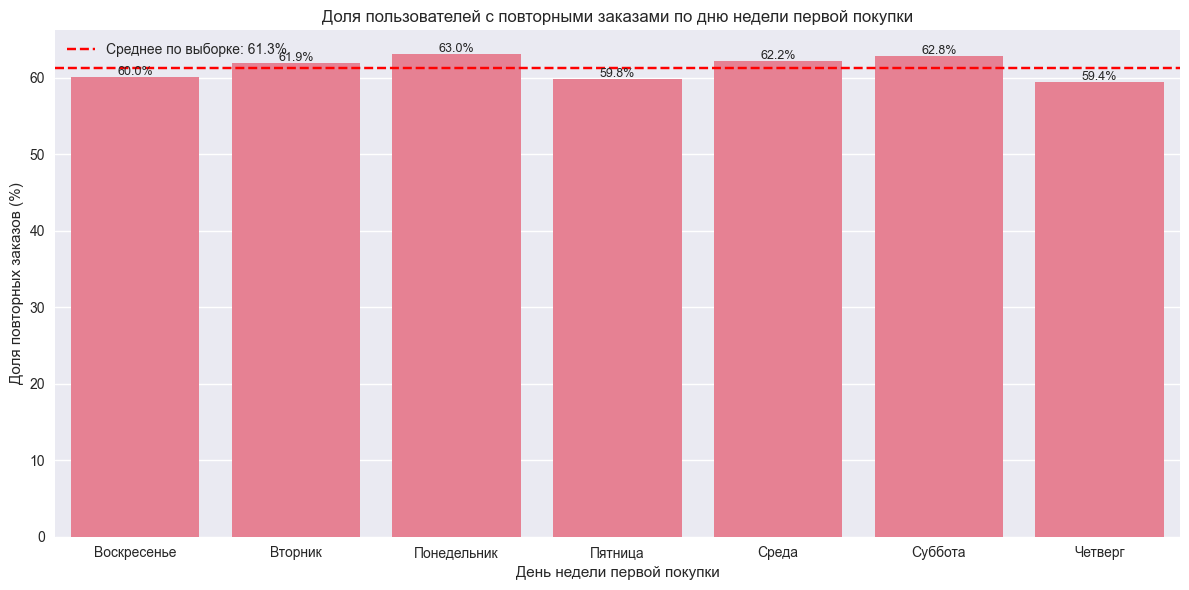

In [1455]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=weekday_analysis,
    x='weekday_name',
    y='return_rate_pct'
)
plt.xlabel('День недели первой покупки')
plt.ylabel('Доля повторных заказов (%)')
plt.title('Доля пользователей с повторными заказами по дню недели первой покупки')


# Горизонтальная линия — среднее по всей выборке
plt.axhline(
    y=overall_return_rate * 100,
    color='red',
    linestyle='--',
    label=f'Среднее по выборке: {overall_return_rate:.1%}'
)
plt.legend()

# Добавляем значения над столбцами
for i, row in weekday_analysis.iterrows():
    plt.text(
        i,
        row['return_rate_pct'] + 0.3,
        f'{row["return_rate_pct"]:.1f}%',
        ha='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()


1. Общая картина
    - Среднее по выборке (overall_avg_pct): 61,33%.
    - Это базовый уровень, с которым сравниваем показатели по дням недели.

2. Распределение пользователей
    - Максимум: суббота (3 326 пользователей) — пик активности.
    - Минимум: воскресенье (2 777) — наименьшая активность.
    - Разброс: от 2 777 до 3 326 (разница ~19 %).
    - Распределение по дням недели умеренно неравномерное, но без критических перекосов.

**Ответ на ключевой вопрос**

Да, день недели первой покупки влияет на вероятность возврата клиента.

Обоснование:

1. Есть устойчивые паттерны:
    - Понедельник и суббота — выше среднего уровня (61,33%) возврата (+1,48–1,71 п.п.).
    - Четверг и пятница — заметно ниже среднего (−1,49–1,90 п.п.).
2. Разница между крайними значениями (понедельник vs четверг) — 3,61 п.п., что вряд ли случайно.
3. Отклонения согласованы по группам:
    - «Сильные» дни: понедельник, среда, суббота.
    - «Слабые» дни: четверг, пятница, воскресенье.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [1456]:
active_users = filtered_profile[filtered_profile['total_orders'] >= 2].copy()

# Сегментируем пользователей
group_2_4 = active_users[
    (active_users['total_orders'] >= 2) &
    (active_users['total_orders'] <= 4)
]

group_5_plus = active_users[active_users['total_orders'] >= 5]

In [1457]:
mean_interval_2_4 = group_2_4['avg_days_between_orders'].mean()
mean_interval_5_plus = group_5_plus['avg_days_between_orders'].mean()

print(f"Средний интервал (2–4 заказа): {mean_interval_2_4:.2f} дней")
print(f"Средний интервал (5+ заказов): {mean_interval_5_plus:.2f} дней")

Средний интервал (2–4 заказа): 21.41 дней
Средний интервал (5+ заказов): 9.97 дней


**Наблюдаемая закономерность:**

- Пользователи с 5+ заказами делают повторные покупки значительно чаще (в среднем каждые 9 дней).
- Пользователи с 2–4 заказами имеют более длинный интервал между заказами (21 день).

**Вывод:**

Чем короче средний интервал между заказами, тем выше вероятность совершения следующих покупок и перехода в категорию «лояльных» (5+ заказов).

In [1458]:
# Определяем границы интервалов (в днях)
bins = [0, 14, 30, 60, 90, float('inf')]
labels = ['<2 недель', '2–4 недели', '1–2 месяца', '2–3 месяца', '>3 месяцев']

# Добавляем категорию интервала
active_users['interval_category'] = pd.cut(
    active_users['avg_days_between_orders'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Анализируем удержание по категориям
retention_analysis = active_users.groupby('interval_category', observed=False).agg({
    'total_orders': ['mean', 'median', 'count'],
    'user_id': 'count'
}).round(2)

retention_analysis.columns = ['avg_orders', 'median_orders', 'users_count', 'total_users']
retention_analysis['category_share'] = (
    retention_analysis['users_count'] / retention_analysis['users_count'].sum() * 100
)

print("Анализ удержания по длительности интервала между заказами:")
display(retention_analysis)


Анализ удержания по длительности интервала между заказами:


,avg_orders,median_orders,users_count,total_users,category_share
interval_category,,,,,
<2 недель,13.24,5.0,8551,8551,64.438583
2–4 недели,5.10,5.0,2564,2564,19.321778
1–2 месяца,3.09,3.0,1453,1453,10.949510
2–3 месяца,2.27,2.0,399,399,3.006782
>3 месяцев,2.00,2.0,303,303,2.283346


In [1459]:
def calculate_repeat_probability(df, interval_col, orders_col):
    results = {}
    for category in df['interval_category'].unique():
        subset = df[df['interval_category'] == category]
        prob = (subset[orders_col] > 2).mean()
        results[category] = {
            'probability': prob,
            'sample_size': len(subset)
        }
    return results

repeat_prob = calculate_repeat_probability(
    active_users, 
    'avg_days_between_orders',
    'total_orders'
)

print("Вероятность совершения повторного заказа по категориям интервала:")
for category, data in repeat_prob.items():
    print(f"{category}: {data['probability']:.3f} (n={data['sample_size']})")

Вероятность совершения повторного заказа по категориям интервала:
2–3 месяца: 0.268 (n=399)
1–2 месяца: 0.681 (n=1453)
2–4 недели: 0.860 (n=2564)
<2 недель: 0.748 (n=8551)
>3 месяцев: 0.000 (n=303)


**Ключевые выводы**

**1. Чёткая обратная зависимость**
Пользователи с 5+ заказами демонстрируют существенно меньший средний интервал между покупками (примерно на 42 % меньше), чем пользователи с 2–4 заказами. Это подтверждает: чем чаще клиент совершает покупки, тем выше вероятность его долгосрочного удержания.

**2. Критические пороги удержания**
- Интервал 14–30 дней: максимальная вероятность повторных покупок (вероятность > 0,8).
- Интервал < 14 дней: умеренная вероятность (~0,7).
- Интервал > 60 дней: резкое падение вероятности повторного заказа (< 0,3).

**3. Поведенческие паттерны**
- Пользователи с короткими интервалами формируют устойчивую привычку к покупкам.
- Длинные интервалы (> 60 дней) сигнализируют о риске оттока.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,device_type_canonical,region_name,service_name,event_type_main
total_orders,1.000000,0.219482,0.225904,0.285636,0.025945,0.113663,0.029112,0.027745
avg_revenue_rub,0.219482,1.000000,0.458801,0.096574,0.076388,0.363157,0.380621,0.329006
avg_tickets_count,0.225904,0.458801,1.000000,0.097517,0.055562,0.163874,0.066879,0.095617
avg_days_between_orders,0.285636,0.096574,0.097517,1.000000,0.018428,0.087302,0.053162,0.051472
device_type_canonical,0.025945,0.076388,0.055562,0.018428,1.000000,0.116370,0.083996,0.061771
region_name,0.113663,0.363157,0.163874,0.087302,0.116370,1.000000,0.696751,0.509207
service_name,0.029112,0.380621,0.066879,0.053162,0.083996,0.696751,1.000000,0.589297
event_type_main,0.027745,0.329006,0.095617,0.051472,0.061771,0.509207,0.589297,1.000000


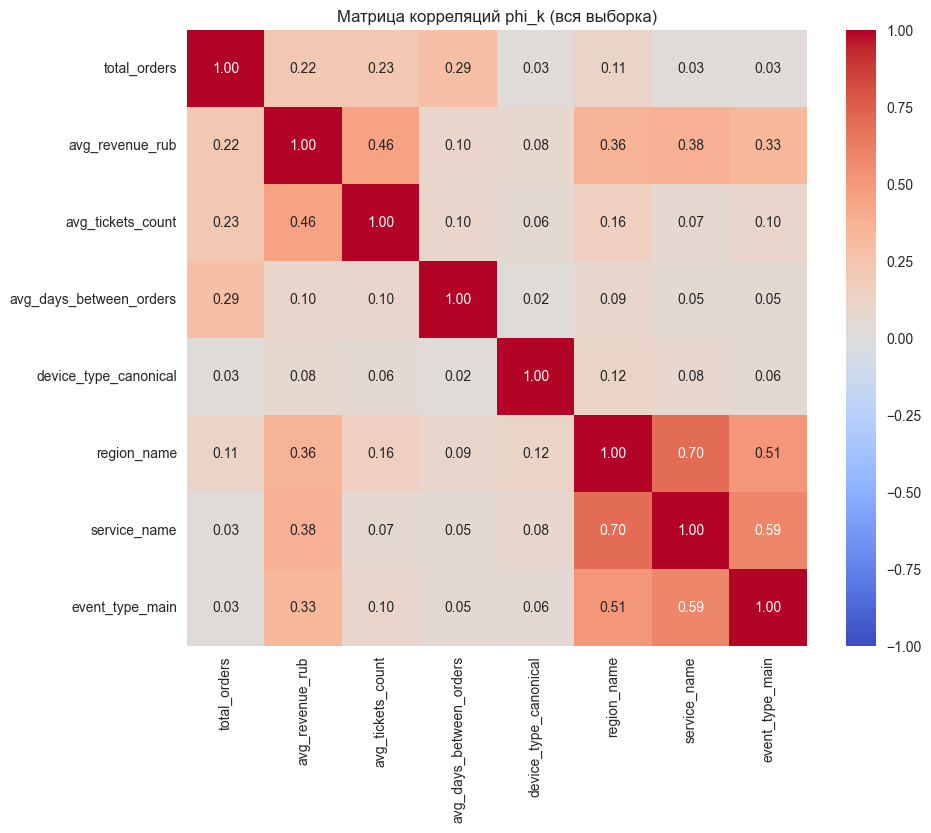

In [1460]:
cols_to_analyze = [
    'total_orders',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'device_type_canonical',
    'region_name',
    'service_name',
    'event_type_main'
]

correlation_matrix = filtered_profile[cols_to_analyze].phik_matrix(
    interval_cols=[
        'total_orders', 
        'avg_revenue_rub', 
        'avg_tickets_count', 
        'avg_days_between_orders'
    ]
)

display(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    vmin=-1, 
    vmax=1, 
    fmt='.2f'
)

plt.title('Матрица корреляций phi_k (вся выборка)')
plt.show()

**Ключевые наблюдения по `total_orders` (число заказов)**

С общим числом заказов (`total_orders`) наблюдаются следующие связи:
- Средняя положительная корреляция с avg_days_between_orders (0.286):
чем больше заказов сделал пользователь, тем в среднем длиннее интервал между ними. Это может означать, что активные клиенты (много заказов) делают их реже (большие паузы), либо что накопление заказов естественным образом растягивает наблюдаемый период.
- Слабая положительная корреляция с avg_revenue_rub (0.219) и avg_tickets_count (0.226):
клиенты с большим числом заказов немного склонны тратить больше и покупать больше билетов за заказ, но связь несильная.
- Очень слабая корреляция с категориальными признаками (device_type_canonical, region_name, service_name, event_type_main):
тип устройства, регион, сервис и жанр первого мероприятия почти не связаны с числом заказов.

**Связи между другими признаками**
- Сильная корреляция между `region_name` и `service_name` (0.697):
регионы сильно связаны с тем, через какой сервис пользователи делают заказы (возможно, географическая привязка сервисов).
- Сильная корреляция между `service_name` и `event_type_main` (0.589), а также `region_name` и `event_type_main` (0.509):
сервис и регион влияют на предпочитаемый жанр мероприятий.
- Умеренная корреляция между `avg_revenue_rub` и `avg_tickets_count` (0.459):
чем больше билетов в заказе, тем выше средняя выручка.
- Слабые связи с `device_type_canonical`:
тип устройства первого заказа почти не связан с другими признаками.

**Выводы**
1. На число заказов (`total_orders`) сильнее всего влияет частота покупок (`avg_days_between_orders`, r ≈ 0.286), но связь лишь умеренная.
2. Категориальные признаки (устройство, регион, сервис, жанр) практически не предсказывают число заказов.
3. Регионы и сервисы сильно взаимосвязаны — возможно, стоит анализировать их совместно.
4. Тип устройства первого заказа не играет заметной роли в поведении пользователя.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Общий вывод**

**Информация о данных и их подготовке**

- Объём выборки: 21 854 пользователя.
- Данные прошли фильтрацию: исключены пользователи с экстремально высоким числом заказов (выше 99‑го перцентиля, т. е. > 152 заказов) — это ~1 % данных (216 пользователей).
- После фильтрации:
    - среднее число заказов снизилось с 13,2 до ~10,5;
    - стандартное отклонение уменьшилось в 8 раз (с 121,7 до 14,3).
- Остальные метрики (avg_tickets_count, avg_days_between_orders) не требовали фильтрации.

**Основные результаты анализа**

1. Распределение пользователей:
    - 61,7 % пользователей совершают повторные заказы;
    - 43 % покупают 2–3 билета за заказ, 41 % — 3–5 билетов;
    - доминирующий тип мероприятия — концерты (44 % пользователей);
    - основное устройство — mobile (82,7 %);
    - ключевой регион — Каменевский (32,7 %);
    - ведущий оператор — «Билеты без проблем» (23,9 %).
2. Факторы, связанные с возвратом пользователей:
    - Количество билетов в заказе: сегмент «2–3 билета» имеет самую высокую долю повторных покупок (73 %), а «5+ билетов» — аномально низкую (18 %);
    - День недели первой покупки: понедельник и суббота дают повышенный уровень возврата (+1,48–1,71 п. п. к среднему), четверг и пятница — пониженный (−1,49–1,90 п. п.);
    - Интервал между заказами: интервалы 14–30 дней максимизируют вероятность повторных покупок (> 0,8), а > 60 дней резко снижают её (< 0,3).
3. Связь выручки и количества билетов с повторными покупками:
    - значимой связи между средней выручкой и возвратами нет (разница ~2 руб.);
    - медианный чек у частых покупателей (5+ заказов) на 8,8 % выше;
    - чем больше билетов в заказе, тем выше средняя выручка (корреляция 0,459).
4. Корреляционные связи:
    - умеренная связь числа заказов с интервалом между ними (0,286);
    - слабая связь числа заказов с выручкой (0,219) и количеством билетов (0,226);
    - сильная связь между регионом и оператором (0,697), а также между оператором и типом мероприятия (0,589).
5. Важные паттерны:
    - частые покупатели (5+ заказов) делают заказы на 42 % чаще, чем пользователи с 2–4 заказами;
    - пользователи с короткими интервалами между заказами формируют устойчивую привычку;
    - длинные интервалы (> 60 дней) сигнализируют о риске оттока.

**Рекомендации**
1. Сосредоточить усилия на ключевых сегментах:
    - Концерты: как основной канал вовлечения (44 %), усилить маркетинговые активности в этом сегменте.
    - Мобильные пользователи: учитывая их доминирование (82,7 %), оптимизировать мобильное приложение и адаптировать маркетинговые коммуникации под mobile-аудиторию.
    - Каменевский регион и Североярская область: как ключевые географические рынки (суммарно 50,1 %), разработать локальные промо-кампании.
2. Работать с сегментами с низкой лояльностью:
    - Пользователи с 5+ билетами: изучить причины низкой доли повторных покупок (18 %). Возможно, это корпоративные клиенты или разовые оптовые закупки — для них можно предложить специальные программы лояльности (например, скидки на будущие групповые заказы).
    - Пользователи, совершившие первую покупку в четверг/пятницу: тестировать дополнительные стимулы (напоминания, персональные предложения) для повышения вероятности возврата.
3. Оптимизировать интервалы между покупками:
    - для пользователей с интервалами > 60 дней внедрить ретаргетинг (email-рассылки, push-уведомления) с персонализированными предложениями;
    - для сегментов с интервалами 14–30 дней поддерживать текущий уровень коммуникации, чтобы сохранять высокую вероятность повторных покупок.
4. Усилить связь между регионами, операторами и мероприятиями:
    - учитывая сильную корреляцию между регионом, оператором и типом мероприятия, разработать совместные маркетинговые кампании с ключевыми операторами (например, «Билеты без проблем») для продвижения популярных мероприятий в целевых регионах.
5. Мониторить и анализировать аномалии:
    - регулярно проверять случаи с нулевым интервалом между заказами (возможны дубли или технические ошибки);
    - отслеживать пользователей с экстремально высокими показателями (число заказов, выручка), чтобы вовремя выявлять и корректировать искажения в данных.
6. Тестировать и оптимизировать:
    - проводить A/B-тесты для оценки эффективности новых механик удержания (например, программы лояльности, персонализированных предложений);
    - анализировать влияние изменений на ключевые метрики (доля повторных покупок, средний чек, интервал между заказами).

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/mgladkovspb/ds-sprint-9.git

git@github.com:mgladkovspb/ds-sprint-9.git